### Описание проекта
Реализация системы детектирования медицинских масок на лицах с использованием методов глубокого обучения.

### Датасет
- **Обучающая выборка**: 10 000 изображений (5000 с маской + 5000 без маски)
- **Валидационная выборка**: 800 изображений (400 + 400)
- **Тестовая выборка**: 992 изображения (483 + 509)


## 1. Импорт библиотек

In [39]:
import os

os.environ['KERAS_HOME'] = r'D:\Users\imageprocessing\.keras'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f"KERAS_HOME установлен: {os.environ['KERAS_HOME']}")


KERAS_HOME установлен: D:\Users\imageprocessing\.keras


In [40]:
import os
os.environ['KERAS_HOME'] = r'D:\Users\imageprocessing\.keras'
os.environ['TMP'] = r'D:\Users\imageprocessing\Temp'
os.environ['TEMP'] = r'D:\Users\imageprocessing\Temp'

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## 2. Конфигурация

In [42]:
BASE_DIR = Path("Dataset/Face_Mask_Dataset")
TRAIN_DIR = BASE_DIR / "Train"
VALID_DIR = BASE_DIR / "Validation"
TEST_DIR = BASE_DIR / "Test"

IMG_SIZE = 64          
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64        
EPOCHS = 5             
LEARNING_RATE = 0.001
CLASSES = ['WithMask', 'WithoutMask']

print("Конфигурация загружена")
for dir_path, name in [(TRAIN_DIR, "Обучение"), (VALID_DIR, "Валидация"), (TEST_DIR, "Тест")]:
    print(f"{name}: {'Найдено' if dir_path.exists() else 'Не найдено'}")

Конфигурация загружена
Обучение: Найдено
Валидация: Найдено
Тест: Найдено


## 3. Разведочный анализ данных (EDA)

In [43]:
def count_images(directory):
    counts = {}
    for class_name in CLASSES:
        class_dir = directory / class_name
        if class_dir.exists():
            counts[class_name] = len(list(class_dir.glob('*.png'))) + len(list(class_dir.glob('*.jpg')))
        else:
            counts[class_name] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
valid_counts = count_images(VALID_DIR)
test_counts = count_images(TEST_DIR)

print("Статистика датасета:")
print(f"Обучение: {sum(train_counts.values())} (С маской: {train_counts['WithMask']}, Без маски: {train_counts['WithoutMask']})")
print(f"Валидация: {sum(valid_counts.values())}")
print(f"Тест: {sum(test_counts.values())}")

Статистика датасета:
Обучение: 10000 (С маской: 5000, Без маски: 5000)
Валидация: 800
Тест: 992


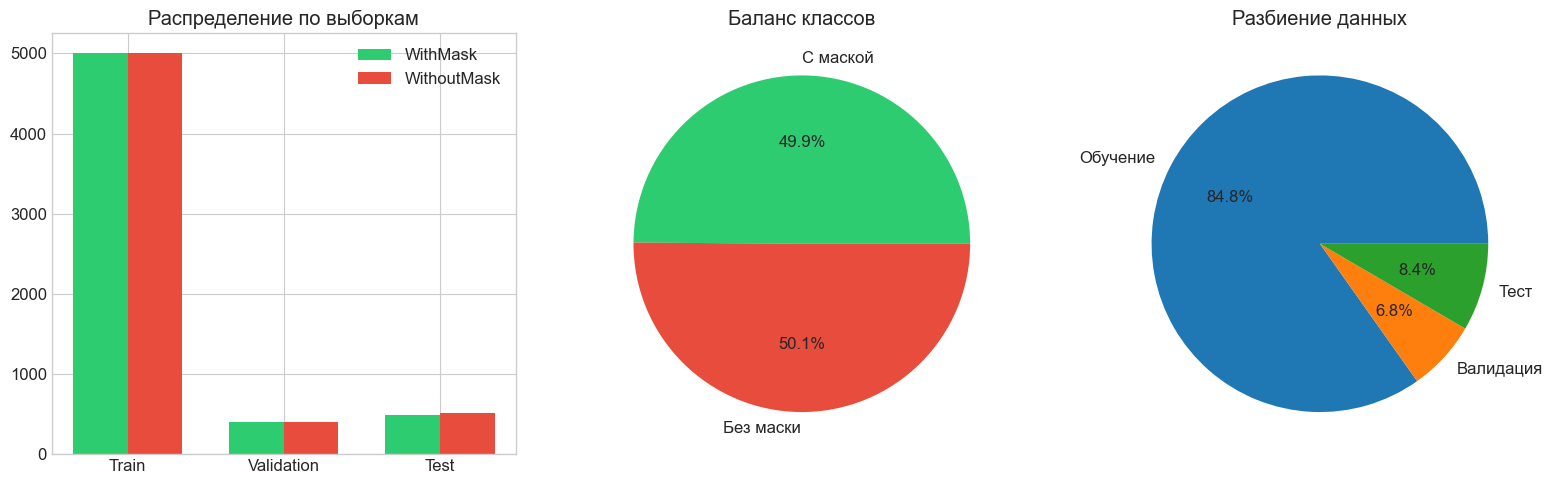

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#2ecc71', '#e74c3c']

datasets = ['Train', 'Validation', 'Test']
with_mask = [train_counts['WithMask'], valid_counts['WithMask'], test_counts['WithMask']]
without_mask = [train_counts['WithoutMask'], valid_counts['WithoutMask'], test_counts['WithoutMask']]

x = np.arange(len(datasets))
width = 0.35
axes[0].bar(x - width/2, with_mask, width, label='WithMask', color=colors[0])
axes[0].bar(x + width/2, without_mask, width, label='WithoutMask', color=colors[1])
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].set_title('Распределение по выборкам')

total_with = sum(with_mask)
total_without = sum(without_mask)
axes[1].pie([total_with, total_without], labels=['С маской', 'Без маски'], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Баланс классов')

total_sizes = [sum(train_counts.values()), sum(valid_counts.values()), sum(test_counts.values())]
axes[2].pie(total_sizes, labels=['Обучение', 'Валидация', 'Тест'], autopct='%1.1f%%')
axes[2].set_title('Разбиение данных')

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=150)
plt.show()

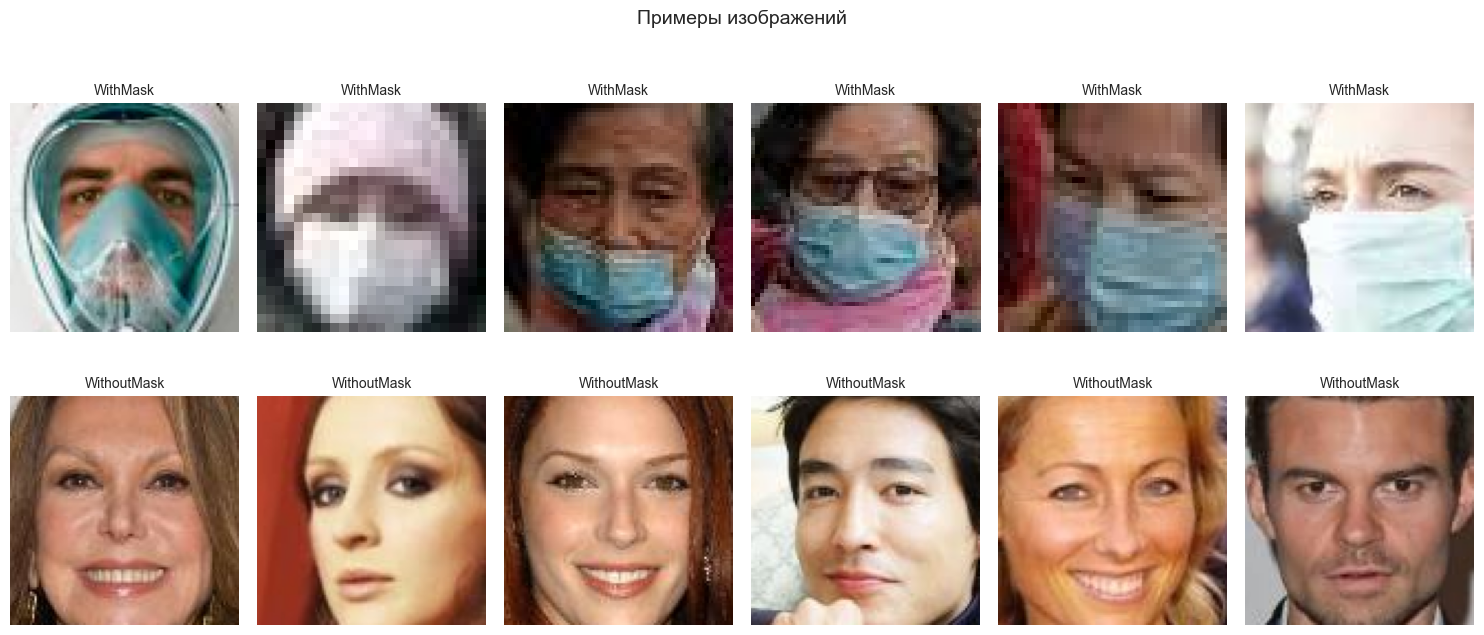

In [45]:
fig, axes = plt.subplots(2, 6, figsize=(15, 7))
for idx, class_name in enumerate(CLASSES):
    class_dir = TRAIN_DIR / class_name
    images = list(class_dir.glob('*.png'))[:6]
    for j, img_path in enumerate(images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        axes[idx, j].set_title(class_name, fontsize=10)
plt.suptitle('Примеры изображений', fontsize=14)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150)
plt.show()

## 4. Предобработка данных и аугментация

In [46]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=SEED
)
validation_generator = val_test_datagen.flow_from_directory(
    VALID_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

print(f"Обучение: {train_generator.samples} изображений")
print(f"Валидация: {validation_generator.samples} изображений")
print(f"Тест: {test_generator.samples} изображений")
print(f"Индексы классов: {train_generator.class_indices}")

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Обучение: 10000 изображений
Валидация: 800 изображений
Тест: 992 изображений
Индексы классов: {'WithMask': 0, 'WithoutMask': 1}


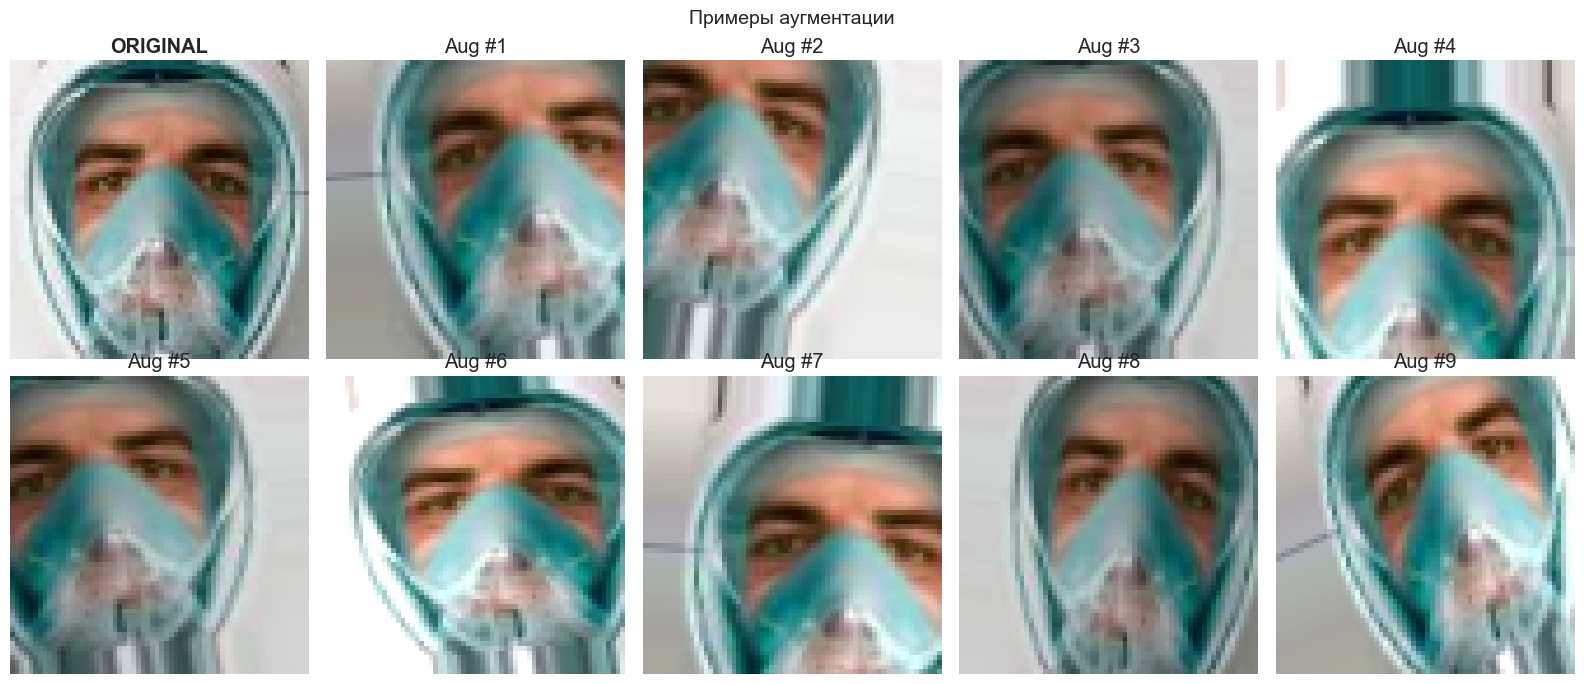

In [47]:
sample_image = list((TRAIN_DIR / 'WithMask').glob('*.png'))[0]
img = cv2.imread(str(sample_image))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_array = img.reshape((1,) + img.shape)

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes[0, 0].imshow(img)
axes[0, 0].set_title('ORIGINAL', fontweight='bold')
axes[0, 0].axis('off')

augmented_iterator = train_datagen.flow(img_array, batch_size=1)
for i in range(1, 10):
    row, col = i // 5, i % 5
    axes[row, col].imshow(next(augmented_iterator)[0])
    axes[row, col].set_title(f'Aug #{i}')
    axes[row, col].axis('off')
plt.suptitle('Примеры аугментации', fontsize=14)
plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150)
plt.show()

## 5. Построение моделей

### 5.1 Собственная CNN модель

In [48]:
def create_custom_cnn(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = create_custom_cnn(IMG_SHAPE)
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 3,408,417 (13.00 MB)

 Trainable params: 3,404,961 (12.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

### 5.2 Трансферное обучение с MobileNetV2

In [49]:
def create_transfer_learning_model(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model, base_model

tl_model, base_model = create_transfer_learning_model(IMG_SHAPE)
tl_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
tl_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,481 (10.00 MB)

 Trainable params: 361,729 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## 6. Обучение моделей

In [50]:
def create_callbacks(model_name):
    return [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        callbacks.ModelCheckpoint(filepath=f'{model_name}_best.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]

In [51]:
print("Обучение CNN модели...")
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('cnn_model'),
    verbose=1
)
print("Обучение CNN завершено")

Обучение CNN модели...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.8571 - loss: 0.3310
Epoch 1: val_accuracy improved from None to 0.59896, saving model to cnn_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 137s 830ms/step - accuracy: 0.9045 - loss: 0.2436 - val_accuracy: 0.5990 - val_loss: 1.4873 - learning_rate: 0.0010
Epoch 2/5
  1/156 ━━━━━━━━━━━━━━━━━━━━ 2:02 790ms/step - accuracy: 0.9375 - loss: 0.1454
Epoch 2: val_accuracy improved from 0.59896 to 0.63021, saving model to cnn_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9375 - loss: 0.1454 - val_accuracy: 0.6302 - val_loss: 1.3449 - learning_rate: 0.0010
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9426 - loss: 0.1556
Epoch 3: val_accuracy improved from 0.63021 to 0.86589, saving model to cnn_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 131s 839ms/step - accuracy: 0.9444 - loss: 0.1514 - val_accuracy: 0.8659 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 

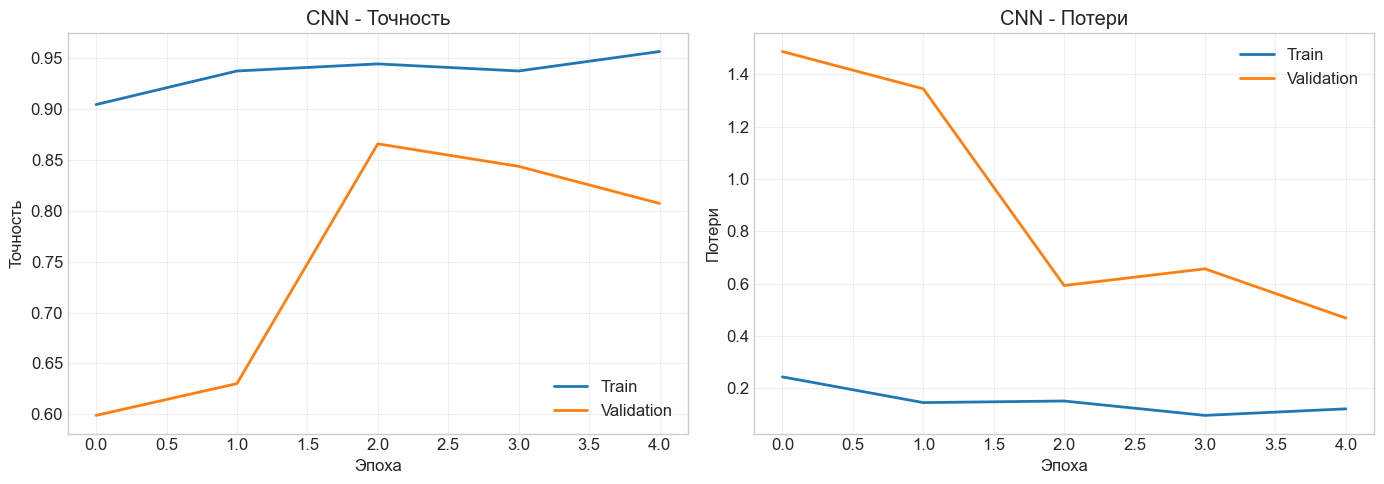

Лучшая точность на валидации: 0.8659


In [52]:
def plot_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].set_title(f'{model_name} - Точность')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Потери')
    axes[1].set_title(f'{model_name} - Потери')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_history.png', dpi=150)
    plt.show()
    
    print(f"Лучшая точность на валидации: {max(history.history['val_accuracy']):.4f}")

plot_history(cnn_history, 'CNN')

Обучение MobileNetV2 модели...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8827 - loss: 0.2722
Epoch 1: val_accuracy improved from None to 0.98828, saving model to mobilenet_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.9277 - loss: 0.1821 - val_accuracy: 0.9883 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 2/5
  1/156 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9531 - loss: 0.0740
Epoch 2: val_accuracy improved from 0.98828 to 0.98958, saving model to mobilenet_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9531 - loss: 0.0740 - val_accuracy: 0.9896 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9560 - loss: 0.1176
Epoch 3: val_accuracy improved from 0.98958 to 0.99219, saving model to mobilenet_model_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.9567 - loss: 0.1150 - val_accuracy: 0.9922 - val_loss: 0.0291 - learni

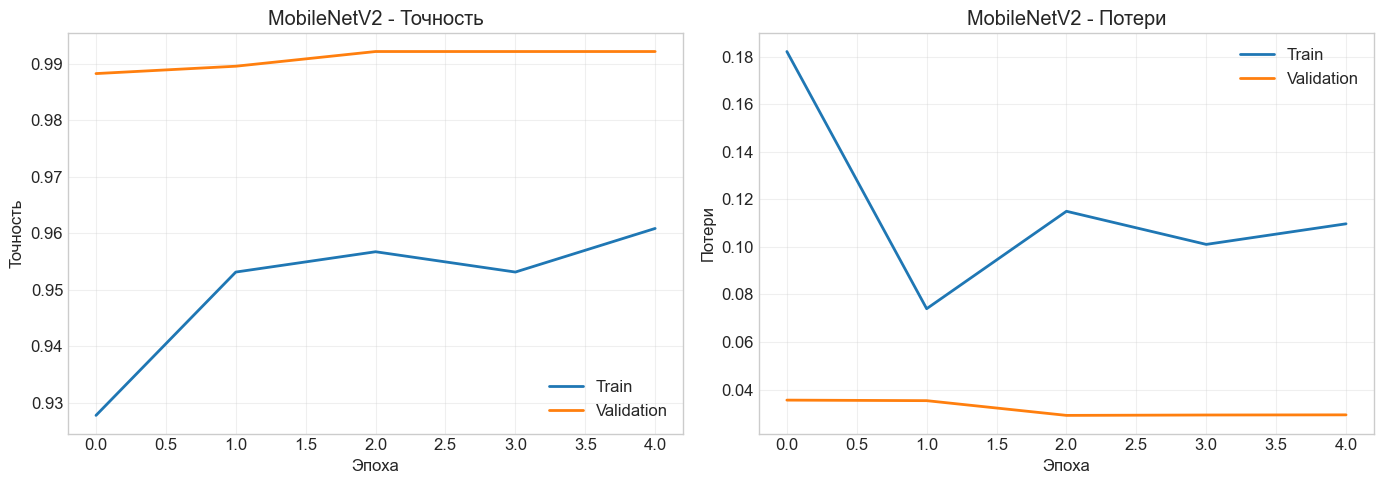

Лучшая точность на валидации: 0.9922


In [53]:
print("Обучение MobileNetV2 модели...")
tl_history = tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('mobilenet_model'),
    verbose=1
)
print("Обучение MobileNetV2 завершено")
plot_history(tl_history, 'MobileNetV2')

### Тонкая настройка (Fine-Tuning)

In [54]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

tl_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

print(f"Тонкая настройка начиная со слоя {fine_tune_at}")
print(f"Обучаемых слоёв: {len(base_model.layers) - fine_tune_at}")

Тонкая настройка начиная со слоя 100
Обучаемых слоёв: 54


In [55]:
FINE_TUNE_EPOCHS = 10
initial_epochs = len(tl_history.history['accuracy'])

print("Начало тонкой настройки...")
fine_tune_history = tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=initial_epochs + FINE_TUNE_EPOCHS,
    initial_epoch=initial_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=create_callbacks('mobilenet_finetuned'),
    verbose=1
)
print("Тонкая настройка завершена")

Начало тонкой настройки...
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7742 - loss: 0.6189
Epoch 6: val_accuracy improved from None to 0.91927, saving model to mobilenet_finetuned_best.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 56s 291ms/step - accuracy: 0.8116 - loss: 0.5019 - val_accuracy: 0.9193 - val_loss: 0.2120 - learning_rate: 1.0000e-05
Epoch 7/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.8281 - loss: 0.4162
Epoch 7: val_accuracy did not improve from 0.91927
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8281 - loss: 0.4162 - val_accuracy: 0.9193 - val_loss: 0.2128 - learning_rate: 1.0000e-05
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8788 - loss: 0.3159
Epoch 8: val_accuracy did not improve from 0.91927
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.8853 - loss: 0.2965 - val_accuracy: 0.8919 - val_loss: 0.3044 - learning_rate: 1.0000e-05
Epoch 9/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accurac

## 7. Оценка моделей

In [56]:
test_generator.reset()
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"CNN - Точность на тесте: {cnn_test_acc:.4f}, Потери: {cnn_test_loss:.4f}")

test_generator.reset()
tl_test_loss, tl_test_acc = tl_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"MobileNetV2 - Точность на тесте: {tl_test_acc:.4f}, Потери: {tl_test_loss:.4f}")

print("\nСравнение моделей:")
print(f"CNN: {cnn_test_acc*100:.2f}%")
print(f"MobileNetV2: {tl_test_acc*100:.2f}%")
best_model = tl_model if tl_test_acc > cnn_test_acc else cnn_model
best_name = 'MobileNetV2' if tl_test_acc > cnn_test_acc else 'CNN'

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.8333 - loss: 0.4095
CNN - Точность на тесте: 0.8333, Потери: 0.4095
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9229 - loss: 0.2200
MobileNetV2 - Точность на тесте: 0.9229, Потери: 0.2200

Сравнение моделей:
CNN: 83.33%
MobileNetV2: 92.29%


In [57]:
def get_predictions(model, generator):
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = generator.classes
    min_len = min(len(predicted_classes), len(true_classes))
    return predictions[:min_len], predicted_classes[:min_len], true_classes[:min_len]

cnn_preds, cnn_pred_classes, cnn_true_classes = get_predictions(cnn_model, test_generator)
tl_preds, tl_pred_classes, tl_true_classes = get_predictions(tl_model, test_generator)

print("Отчёт классификации CNN:")
print(classification_report(cnn_true_classes, cnn_pred_classes, target_names=['С маской', 'Без маски']))
print("\nОтчёт классификации MobileNetV2:")
print(classification_report(tl_true_classes, tl_pred_classes, target_names=['С маской', 'Без маски']))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step
Отчёт классификации CNN:
              precision    recall  f1-score   support

    С маской       0.75      0.99      0.85       483
   Без маски       0.98      0.69      0.81       509

    accuracy                           0.83       992
   macro avg       0.86      0.84      0.83       992
weighted avg       0.87      0.83      0.83       992


Отчёт классификации MobileNetV2:
              precision    recall  f1-score   support

    С маской       1.00      0.85      0.92       483
   Без маски       0.87      1.00      0.93       509

    accuracy                           0.93       992
   macro avg       0.94      0.92      0.92       992
weighted avg       0.93      0.93      0.92       992



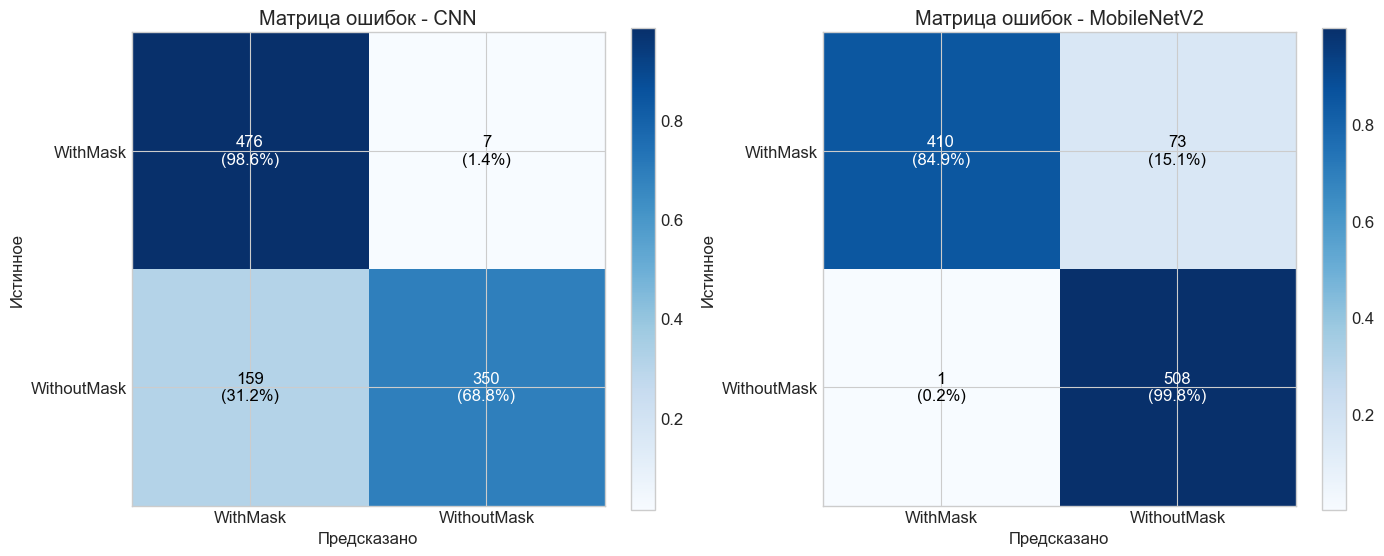

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (true_c, pred_c, name) in enumerate([
    (cnn_true_classes, cnn_pred_classes, 'CNN'),
    (tl_true_classes, tl_pred_classes, 'MobileNetV2')
]):
    cm = confusion_matrix(true_c, pred_c)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = axes[idx].imshow(cm_norm, cmap='Blues')
    axes[idx].figure.colorbar(im, ax=axes[idx], fraction=0.046)
    axes[idx].set(xticks=[0,1], yticks=[0,1], xticklabels=CLASSES, yticklabels=CLASSES)
    axes[idx].set_xlabel('Предсказано')
    axes[idx].set_ylabel('Истинное')
    axes[idx].set_title(f'Матрица ошибок - {name}')
    for i in range(2):
        for j in range(2):
            axes[idx].text(j, i, f'{cm[i,j]}\n({cm_norm[i,j]:.1%})', ha='center', va='center',
                          color='white' if cm_norm[i,j] > 0.5 else 'black')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

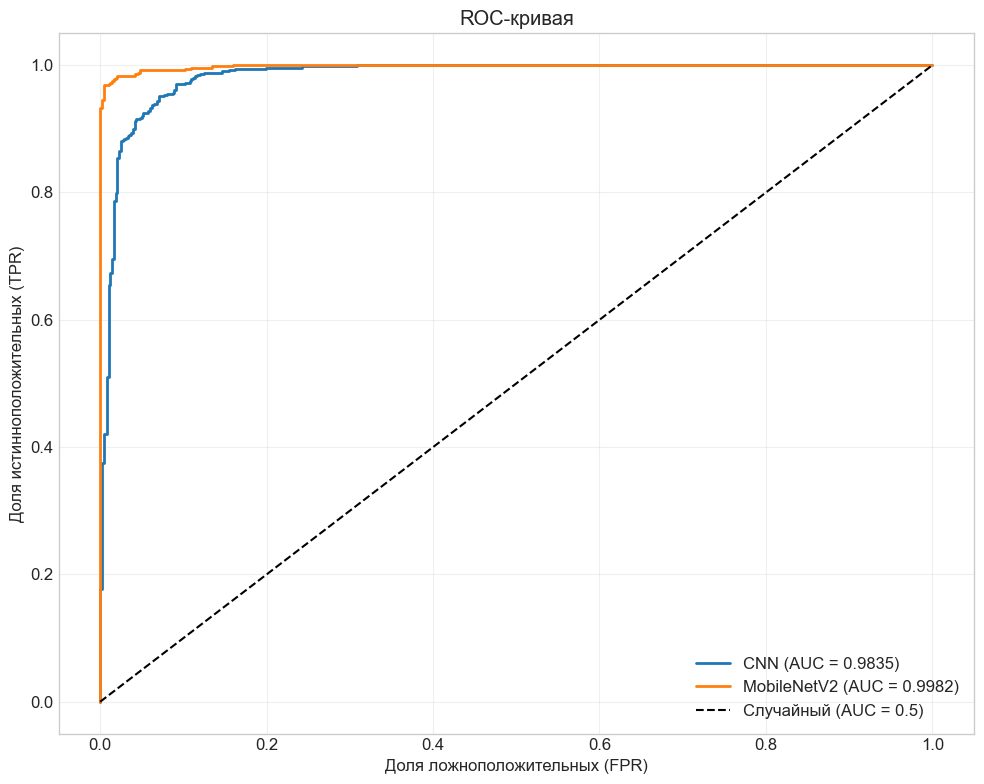

CNN AUC: 0.9835
MobileNetV2 AUC: 0.9982


In [59]:
fig, ax = plt.subplots(figsize=(10, 8))

cnn_fpr, cnn_tpr, _ = roc_curve(cnn_true_classes, cnn_preds)
cnn_auc = auc(cnn_fpr, cnn_tpr)
ax.plot(cnn_fpr, cnn_tpr, linewidth=2, label=f'CNN (AUC = {cnn_auc:.4f})')

tl_fpr, tl_tpr, _ = roc_curve(tl_true_classes, tl_preds)
tl_auc = auc(tl_fpr, tl_tpr)
ax.plot(tl_fpr, tl_tpr, linewidth=2, label=f'MobileNetV2 (AUC = {tl_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', label='Случайный (AUC = 0.5)')
ax.set_xlabel('Доля ложноположительных (FPR)')
ax.set_ylabel('Доля истинноположительных (TPR)')
ax.set_title('ROC-кривая')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150)
plt.show()

print(f"CNN AUC: {cnn_auc:.4f}")
print(f"MobileNetV2 AUC: {tl_auc:.4f}")

## 8. Визуализация предсказаний

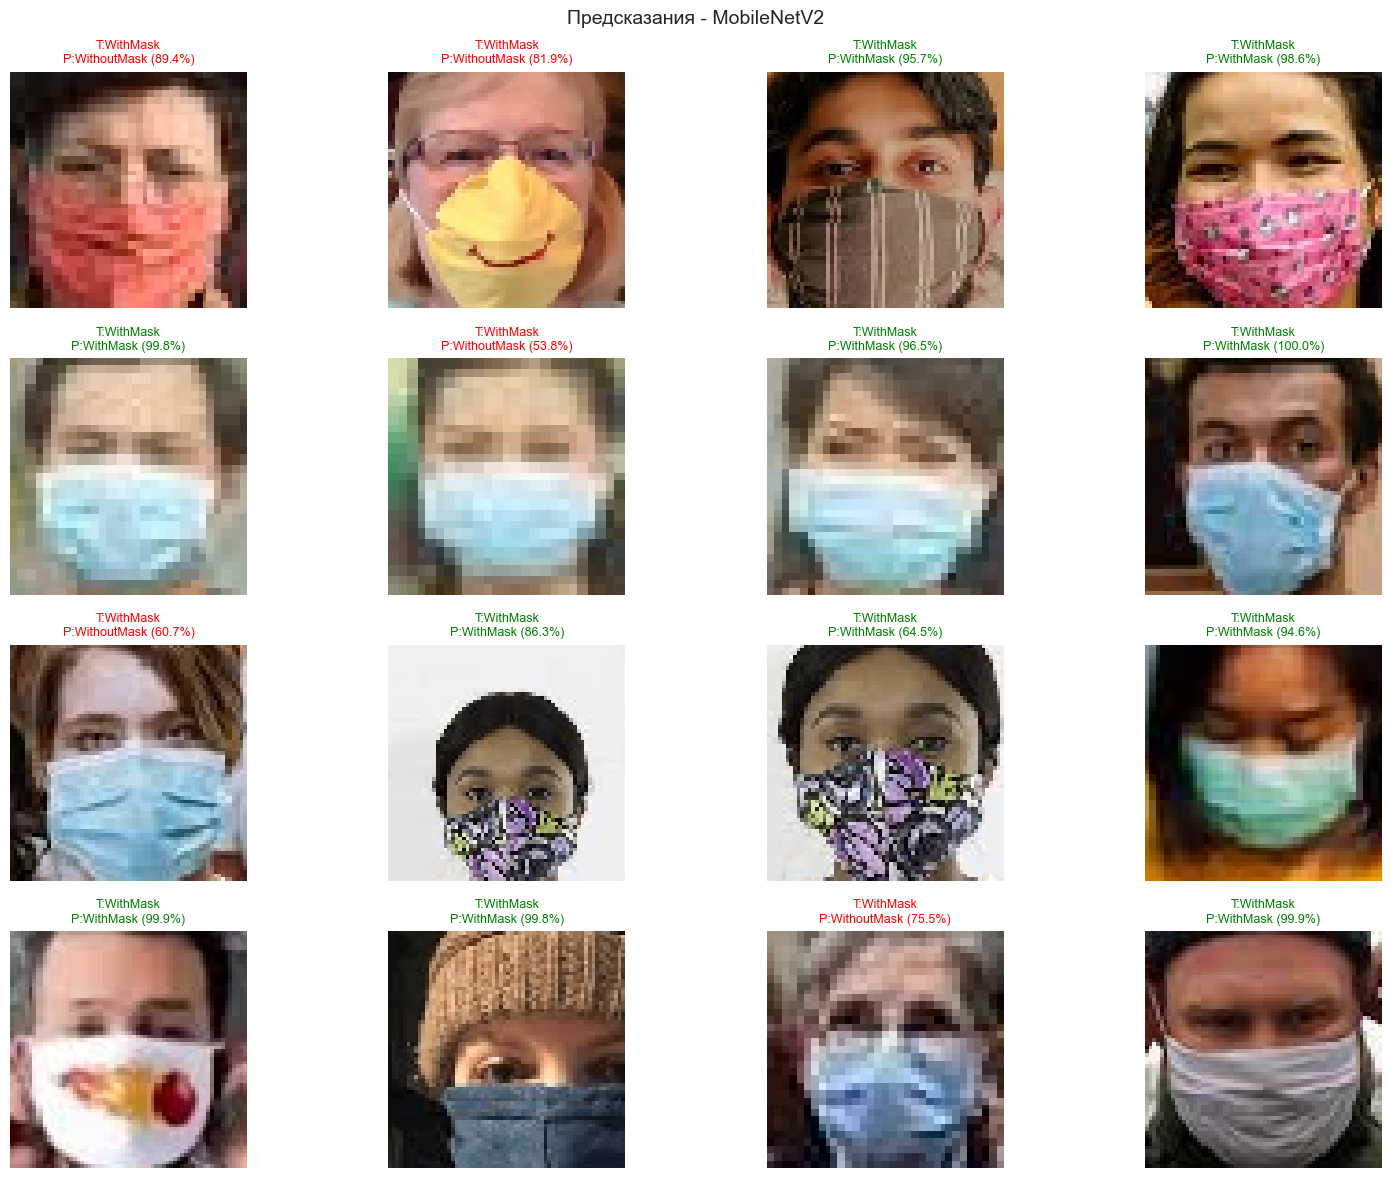

In [60]:
test_generator.reset()
images, labels = next(test_generator)
predictions = best_model.predict(images, verbose=0)
pred_classes = (predictions > 0.5).astype(int).flatten()

class_names = {v: k for k, v in test_generator.class_indices.items()}

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i in range(16):
    row, col = i // 4, i % 4
    axes[row, col].imshow(images[i])
    true_label = int(labels[i])
    pred_label = pred_classes[i]
    color = 'green' if true_label == pred_label else 'red'
    conf = predictions[i][0] if pred_label == 1 else 1 - predictions[i][0]
    axes[row, col].set_title(f'T:{class_names[true_label]}\nP:{class_names[pred_label]} ({conf:.1%})', color=color, fontsize=9)
    axes[row, col].axis('off')

plt.suptitle(f'Предсказания - {best_name}', fontsize=14)
plt.tight_layout()
plt.savefig('predictions.png', dpi=150)
plt.show()

## 9. Сохранение моделей

In [61]:
os.makedirs('saved_models', exist_ok=True)
cnn_model.save('saved_models/cnn_face_mask_model.keras')
tl_model.save('saved_models/mobilenet_face_mask_model.keras')
print("Модели сохранены")

for f in os.listdir('saved_models'):
    size = os.path.getsize(f'saved_models/{f}') / (1024*1024)
    print(f"  {f}: {size:.2f} MB")

Модели сохранены
  cnn_face_mask_model.keras: 39.15 MB
  mobilenet_face_mask_model.keras: 27.58 MB


## 10. Функция предсказания

In [62]:
def predict_mask(image_path, model, img_size=128, show=True):
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    prob = model.predict(img_batch, verbose=0)[0][0]
    prediction = 'WithoutMask' if prob > 0.5 else 'WithMask'
    confidence = prob if prob > 0.5 else 1 - prob
    
    if show:
        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        color = 'red' if prediction == 'WithoutMask' else 'green'
        plt.title(f'{prediction} ({confidence:.1%})', color=color, fontsize=14)
        plt.axis('off')
        plt.show()
    
    return prediction, confidence

print("Тестирование функции предсказания:")
test_imgs = list((TEST_DIR / 'WithMask').glob('*.png'))[:2] + list((TEST_DIR / 'WithoutMask').glob('*.png'))[:2]
for img_path in test_imgs:
    pred, conf = predict_mask(img_path, best_model, IMG_SIZE, show=False)
    result = 'Без маски' if pred == 'WithoutMask' else 'С маской'
    print(f"  {img_path.name}: {result} ({conf:.1%})")

Тестирование функции предсказания:
  1163.png: Без маски (99.0%)
  1174.png: Без маски (89.1%)
  1.png: Без маски (100.0%)
  1000.png: Без маски (100.0%)


## 11. Итоги

In [64]:
print("\nРезультаты:")
print(f"  Точность CNN на тесте: {cnn_test_acc*100:.2f}%")
print(f"  Точность MobileNetV2 на тесте: {tl_test_acc*100:.2f}%")
print(f"  AUC CNN: {cnn_auc:.4f}")
print(f"  AUC MobileNetV2: {tl_auc:.4f}")
print(f"\nЛучшая модель: {best_name}")


Результаты:
  Точность CNN на тесте: 83.33%
  Точность MobileNetV2 на тесте: 92.29%
  AUC CNN: 0.9835
  AUC MobileNetV2: 0.9982

Лучшая модель: MobileNetV2
